In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA
from sklearn.cluster import OPTICS
import optuna
import logging
import sys
from sklearn.metrics import silhouette_score
import plotly.express as px
plt.rcParams['figure.figsize'] = [15, 5]
plt.style.use('seaborn-deep');

In [2]:
asks = pd.read_csv('Asks.csv', header=None)
bids = pd.read_csv('Bids.csv', header=None)

col_names = ['time']
lv = 1
for i in range(1, asks.shape[1], 3):
    col_names.append('order'+str(lv))
    col_names.append('price'+str(lv))
    col_names.append('volume'+str(lv))
    lv += 1

asks.columns = col_names
bids.columns = col_names
asks.head(3)

,time,order1,price1,volume1,order2,price2,volume2,order3,price3,volume3,...,volume97,order98,price98,volume98,order99,price99,volume99,order100,price100,volume100
0,1.604030e+09,53001558049,13437.000000,-1.000000,53006686518,13437.000000,-0.400040,53006729547,13437.0,-0.022328,...,-4.199900,53006740985,13468.0,-1.487708,53001297177,13469.000000,-2.6497,53006634551,13469.000000,-0.312879
1,1.604030e+09,53006737904,13435.043112,-0.041757,53006686518,13436.000000,-0.384894,53006730643,13436.0,-0.106472,...,-0.312879,53006727209,13470.0,-0.148757,52955915169,13470.430324,-0.5689,52986159744,13470.430324,-1.729846
2,1.604030e+09,53006737906,13433.766176,-0.010000,53006737904,13433.874034,-0.041757,53006686518,13434.0,-0.384911,...,-1.114421,52999487837,13465.0,-2.320000,52999487845,13465.000000,-2.3200,53005332351,13465.000000,-3.000000


In [3]:
for l in range(1, 101):
    asks['volume'+str(l)] = asks['volume'+str(l)] * (-1)

In [4]:
n = asks.shape[0]
n_train = 0.1
n_cv = 0.1
asks_train = asks.iloc[:round(n_train*n), :]
bids_train = bids.iloc[:round(n_train*n), :]
asks_cv = asks.iloc[round(n_train*n)+1:round((n_cv+n_train)*n), :]
bids_cv = bids.iloc[round(n_train*n)+1:round((n_cv+n_train)*n), :]
asks_test = asks.iloc[round((n_cv+n_train)*n)+1:, :]
bids_test = bids.iloc[round((n_cv+n_train)*n)+1:, :]

## Features
### Discrete Wavelet Transform
Using Symlets (paper on HMM) with smooth padding

More at: http://www.ece.northwestern.edu/local-apps/matlabhelp/toolbox/wavelet/ch06_a20.html, 
https://pywavelets.readthedocs.io/en/latest/ref/signal-extension-modes.html#ref-modes

In [5]:
import pywt

def DWT(df, lv):
    (ca, cd) = pywt.dwt(df['price'+str(lv)], 'sym2', 'smooth')
    sigma_wv = np.median(np.abs(cd)) / 0.6745
    thresh_wv = sigma_wv * np.sqrt(2*np.log(len(df['price'+str(lv)])))
    cd[np.abs(cd) < thresh_wv] = 0
    ts_recons = pywt.idwt(ca, cd, 'sym2', 'smooth')
    return ts_recons

### Microstructural variables

In [6]:
#Order imbalance
def micro_var(lv, rolling_window, df_bid, df_ask):
    OI = (df_bid['volume'+str(lv)] - df_ask['volume'+str(lv)]) / (df_bid['volume'+str(lv)] + df_ask['volume'+str(lv)]) 
    QS = (df_ask['price'+str(lv)] - df_bid['price'+str(lv)]) * 100 / ((df_ask['price'+str(lv)] + df_bid['price'+str(lv)])/2) 
    ret_sqrt_ask = (np.log(df_ask['price'+str(lv)]) - np.log(df_ask['price'+str(lv)].shift(1)))**2
    ret_sqrt_ask = ret_sqrt_ask.rolling(rolling_window).sum()
    ret_sqrt_bid = (np.log(df_bid['price'+str(lv)]) - np.log(df_bid['price'+str(lv)].shift(1)))**2
    ret_sqrt_bid = ret_sqrt_bid.rolling(rolling_window).sum()
    return  pd.Series(OI), pd.Series(QS), pd.Series(ret_sqrt_ask), pd.Series(ret_sqrt_bid)

In [7]:
def make_df(lv, window, df_bid, df_ask):
    ask_dwt = pd.Series(DWT(df_ask, lv))
    bid_dwt = pd.Series(DWT(df_bid, lv))
    ask_dwt_grad = pd.Series(np.gradient(ask_dwt, 1))
    bid_dwt_grad = pd.Series(np.gradient(bid_dwt, 1))
    ask_prices = df_ask['price' + str(lv)]
    bid_prices = df_bid['price' + str(lv)]
    ask_prices_grad = pd.Series(np.gradient(ask_prices, 1))
    bid_prices_grad = pd.Series(np.gradient(bid_prices, 1))
    imbalance, spread, ask_volatility, bid_volatility = micro_var(lv, window, df_bid, df_ask) #minute window

    df = pd.concat([ask_prices, ask_prices_grad, ask_dwt, ask_dwt_grad, ask_volatility, bid_prices, bid_prices_grad, bid_dwt, bid_dwt_grad, bid_volatility, imbalance, spread], axis = 1)
    names = ['ask_price', 'ask_price_grad', 'ask_dwt', 'ask_dwt_grad', 'ask_volat', 'bid_price', 'bid_price_grad', 'bid_dwt', 'bid_dwt_grad', 'bid_volat', 'imbalance', 'spread']
    df.columns = names
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.drop(columns='index', inplace=True)
    return df

In [8]:
window_size = 9
lv1_df_train = make_df(1, window_size, bids_train, asks_train)
lv2_df_train = make_df(2, window_size, bids_train, asks_train)
lv3_df_train = make_df(3, window_size, bids_train, asks_train)
lv4_df_train = make_df(4, window_size, bids_train, asks_train)
lv5_df_train = make_df(5, window_size, bids_train, asks_train)
lv6_df_train = make_df(6, window_size, bids_train, asks_train)
lv7_df_train = make_df(7, window_size, bids_train, asks_train)
lv8_df_train = make_df(8, window_size, bids_train, asks_train)
lv9_df_train = make_df(9, window_size, bids_train, asks_train)
lv10_df_train = make_df(10, window_size, bids_train, asks_train)

In [9]:
lv1_df_cv = make_df(1, window_size, bids_cv, asks_cv)
lv2_df_cv = make_df(2, window_size, bids_cv, asks_cv)
lv3_df_cv = make_df(3, window_size, bids_cv, asks_cv)
lv4_df_cv = make_df(4, window_size, bids_cv, asks_cv)
lv5_df_cv = make_df(5, window_size, bids_cv, asks_cv)
lv6_df_cv = make_df(6, window_size, bids_cv, asks_cv)
lv7_df_cv = make_df(7, window_size, bids_cv, asks_cv)
lv8_df_cv = make_df(8, window_size, bids_cv, asks_cv)
lv9_df_cv = make_df(9, window_size, bids_cv, asks_cv)
lv10_df_cv = make_df(10, window_size, bids_cv, asks_cv)

lv1_df_test = make_df(1, window_size, bids_test, asks_test)
lv2_df_test = make_df(2, window_size, bids_test, asks_test)
lv3_df_test = make_df(3, window_size, bids_test, asks_test)
lv4_df_test = make_df(4, window_size, bids_test, asks_test)
lv5_df_test = make_df(5, window_size, bids_test, asks_test)
lv6_df_test = make_df(6, window_size, bids_test, asks_test)
lv7_df_test = make_df(7, window_size, bids_test, asks_test)
lv8_df_test = make_df(8, window_size, bids_test, asks_test)
lv9_df_test = make_df(9, window_size, bids_test, asks_test)
lv10_df_test = make_df(10, window_size, bids_test, asks_test)

### Scaling

In [10]:
#let`s see if we have some outliers
def plot_outliers(df):
    fig, axs = plt.subplots(4, 3, sharex=True, figsize=(10,10))
    axs[0, 0].boxplot(df['ask_price'])
    axs[0, 0].set_title('ask_price')
    axs[0, 0].set(ylabel = 'dollars')
    axs[1, 0].boxplot(df['ask_price_grad'])
    axs[1, 0].set_title('ask_price_grad')
    axs[1, 0].set(ylabel = '%')
    axs[2, 0].boxplot(df['ask_dwt'])
    axs[2, 0].set_title('ask_dwt')
    axs[2, 0].set(ylabel = 'dollars')
    axs[3, 0].boxplot(df['ask_dwt_grad'])
    axs[3, 0].set_title('ask_dwt_grad')
    axs[3, 0].set(ylabel = '%')
    axs[0, 1].boxplot(df['ask_volat'])
    axs[0, 1].set_title('ask_volat')
    axs[0, 1].set(ylabel = '%')
    axs[1, 1].boxplot(df['bid_price'])
    axs[1, 1].set_title('bid_price')
    axs[1, 1].set(ylabel = 'dollars')
    axs[2, 1].boxplot(df['bid_price_grad'])
    axs[2, 1].set_title('bid_price_grad')
    axs[2, 1].set(ylabel = '%')
    axs[3, 1].boxplot(df['bid_dwt'])
    axs[3, 1].set_title('bid_dwt')
    axs[3, 1].set(ylabel = 'dollars')
    axs[0, 2].boxplot(df['bid_dwt_grad'])
    axs[0, 2].set_title('bid_dwt_grad')
    axs[0, 2].set(ylabel = '%')
    axs[1, 2].boxplot(df['bid_volat'])
    axs[1, 2].set_title('bid_volat')
    axs[1, 2].set(ylabel = '%')
    axs[2, 2].boxplot(df['imbalance'])
    axs[2, 2].set_title('imbalance')
    axs[2, 2].set(ylabel = '%')
    axs[3, 2].boxplot(df['spread'])
    axs[3, 2].set_title('spread')
    axs[3, 2].set(ylabel = '%')
    fig.tight_layout()

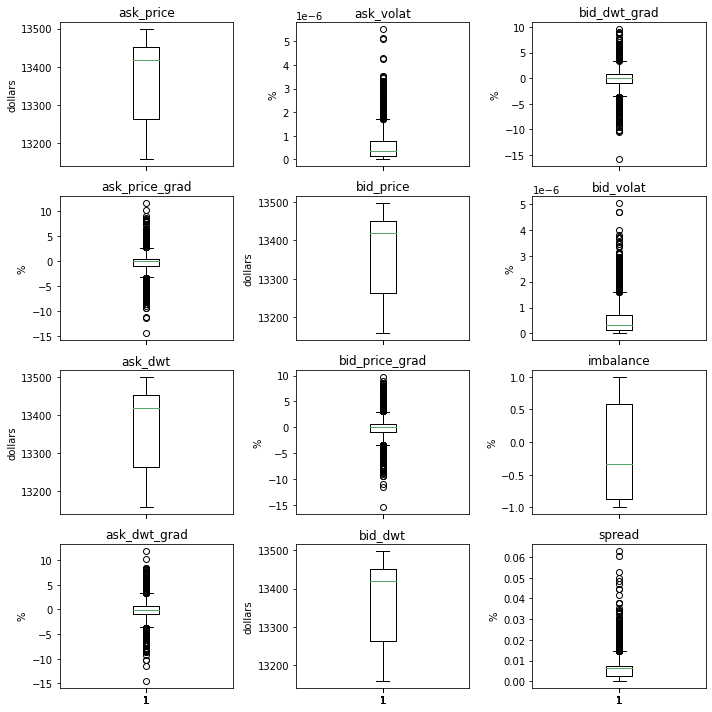

In [11]:
plot_outliers(lv1_df_train)

We can see there are outliers

In [12]:
def plot_distribution(df):
    fig, axs = plt.subplots(4, 3, figsize=(10,10))
    axs[0, 0].hist(df['ask_price'], 50)
    axs[0, 0].set_title('ask_price')
    axs[0, 0].set(xlabel = 'dollars', ylabel = 'count')
    axs[1, 0].hist(df['ask_price_grad'], 50)
    axs[1, 0].set_title('ask_price_grad')
    axs[1, 0].set(xlabel = '%', ylabel = 'count')
    axs[2, 0].hist(df['ask_dwt'], 50)
    axs[2, 0].set_title('ask_dwt')
    axs[2, 0].set(xlabel = 'dollars', ylabel = 'count')
    axs[3, 0].hist(df['ask_dwt_grad'], 50)
    axs[3, 0].set_title('ask_dwt_grad')
    axs[3, 0].set(xlabel = '%', ylabel = 'count')
    axs[0, 1].hist(df['ask_volat'], 50)
    axs[0, 1].set_title('ask_volat')
    axs[0, 1].set(xlabel = '%', ylabel = 'count')
    axs[1, 1].hist(df['bid_price'], 50)
    axs[1, 1].set_title('bid_price')
    axs[1, 1].set(xlabel = 'dollars', ylabel = 'count')
    axs[2, 1].hist(df['bid_price_grad'], 50)
    axs[2, 1].set_title('bid_price_grad')
    axs[2, 1].set(xlabel = '%', ylabel = 'count')
    axs[3, 1].hist(df['bid_dwt'], 50)
    axs[3, 1].set_title('bid_dwt')
    axs[3, 1].set(xlabel = 'dollars', ylabel = 'count')
    axs[0, 2].hist(df['bid_dwt_grad'], 50)
    axs[0, 2].set_title('bid_dwt_grad')
    axs[0, 2].set(xlabel = '%', ylabel = 'count')
    axs[1, 2].hist(df['bid_volat'], 50)
    axs[1, 2].set_title('bid_volat')
    axs[1, 2].set(xlabel = '%', ylabel = 'count')
    axs[2, 2].hist(df['imbalance'], 50)
    axs[2, 2].set_title('imbalance')
    axs[2, 2].set(xlabel = '%', ylabel = 'count')
    axs[3, 2].hist(df['spread'], 50)
    axs[3, 2].set_title('spread')
    axs[3, 2].set(xlabel = '%', ylabel = 'count')
    fig.tight_layout()

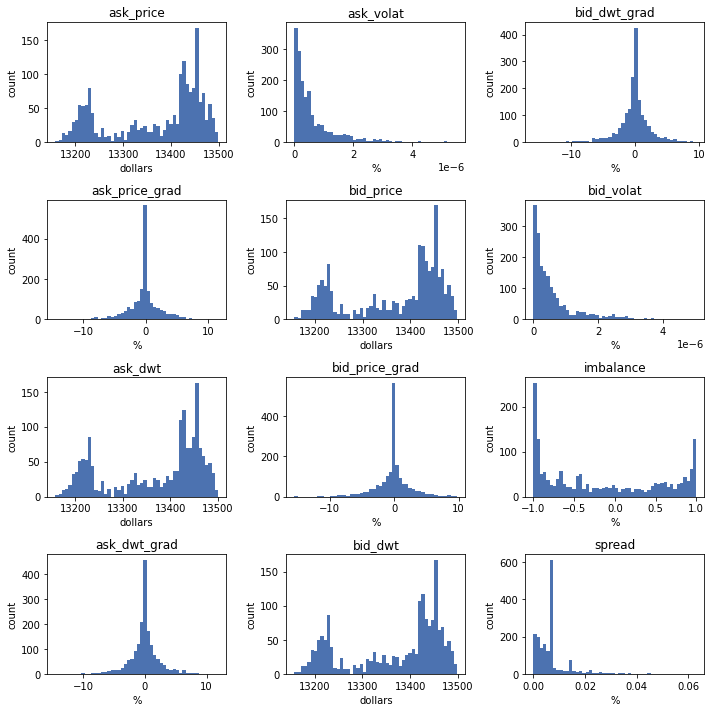

In [13]:
plot_distribution(lv1_df_train)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(lv1_df_train)
lv1_train_scaled = scaler.transform(lv1_df_train)
lv1_train_scaled = pd.DataFrame(lv1_train_scaled, columns=lv1_df_train.columns)

In [15]:
#plot_distribution(lv1_train_scaled)

In [16]:
#plot_outliers(lv1_train_scaled)

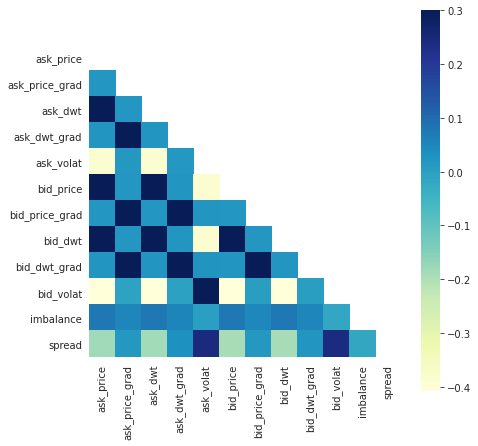

In [17]:
corr = lv1_train_scaled.corr() #low correlation among features
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 7))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, cmap="YlGnBu")

In [20]:
n_components = 7
min_samples = 10
xi = 0.5
pipe = Pipeline([('scaler', KernelPCA(n_components = n_components, kernel='rbf', fit_inverse_transform=True)), ('OPTICS', OPTICS(min_samples = min_samples, xi=xi, metric = 'euclidean', metric_params = None))])
pipe.fit(lv1_train_scaled)

Pipeline(steps=[('scaler',
                 KernelPCA(fit_inverse_transform=True, kernel='rbf',
                           n_components=7)),
                ('OPTICS', OPTICS(metric='euclidean', min_samples=10, xi=0.5))])

I considered Bayesian Optimization, Genetic algorithms (too computationaly expensive, https://en.wikipedia.org/wiki/Genetic_algorithm) and Parzen Trees (https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/003_efficient_optimization_algorithms.html)

https://stats.stackexchange.com/questions/335566/why-a-large-gamma-in-the-rbf-kernel-of-svm-leads-to-a-wiggly-decision-boundary-a

https://stats.stackexchange.com/questions/43943/which-search-range-for-determining-svm-optimal-c-and-gamma-parameters

https://towardsdatascience.com/9-distance-measures-in-data-science-918109d069fa

https://stats.stackexchange.com/questions/6896/best-distance-measure-to-use

https://stats.stackexchange.com/questions/88872/a-routine-to-choose-eps-and-minpts-for-dbscan

In [76]:
def objective(trial):
    n_components = trial.suggest_int("n_components", 24, 50)
    #kernel = trial.suggest_categorical("kernel", ["cosine", "rbf"])
    min_samples = trial.suggest_int("min_samples", 5, 30, 1)
    xi = trial.suggest_uniform('xi', 0, 0.4)
    gamma = trial.suggest_uniform('gamma', 1/2**15, 4.0)
    metric = trial.suggest_categorical("metric", ["cosine", "euclidean"]) #mahalanobis
    
    pipe = Pipeline([('scaler', KernelPCA(n_components = 3, kernel='rbf', gamma=gamma, fit_inverse_transform=False)), ('OPTICS', OPTICS(min_samples = min_samples, xi=xi, metric = metric, metric_params = dict(), cluster_method = 'xi'))])

    for step in range(50):
        pipe.fit(lv1_train_scaled)
        try:
            # Report intermediate objective value.
            intermediate_value = silhouette_score(lv1_train_scaled, pipe[1].labels_, metric = 'euclidean') #choose different metrics
            trial.report(intermediate_value, step)

            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.TrialPruned()
            return silhouette_score(lv1_train_scaled, pipe[1].labels_, metric = 'euclidean')

        except ValueError:
            pass



In [77]:
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(), pruner = optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=20)

with open('OPTICS_lv1.txt', mode='a') as file:
    file.write(str(study.best_params))
    file.close()

16733098571644808 and parameters: {'n_components': 41, 'min_samples': 20, 'xi': 0.18900139250237769, 'gamma': 0.4190876091155945, 'metric': 'cosine'}. Best is trial 5 with value: 0.464331868183807.
[I 2021-02-20 12:15:03,144] Trial 8 finished with value: 0.39158559295007056 and parameters: {'n_components': 43, 'min_samples': 23, 'xi': 0.09866903563425128, 'gamma': 2.8226827375424004, 'metric': 'euclidean'}. Best is trial 5 with value: 0.464331868183807.
Trial 8 finished with value: 0.39158559295007056 and parameters: {'n_components': 43, 'min_samples': 23, 'xi': 0.09866903563425128, 'gamma': 2.8226827375424004, 'metric': 'euclidean'}. Best is trial 5 with value: 0.464331868183807.
Trial 8 finished with value: 0.39158559295007056 and parameters: {'n_components': 43, 'min_samples': 23, 'xi': 0.09866903563425128, 'gamma': 2.8226827375424004, 'metric': 'euclidean'}. Best is trial 5 with value: 0.464331868183807.
Trial 8 finished with value: 0.39158559295007056 and parameters: {'n_component

KeyboardInterrupt: 

In [105]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

#plot_param_importances(study)

In [104]:
#plot_slice(study)

In [103]:
#plot_contour(study)

In [102]:
#plot_optimization_history(study)

In [101]:
#plot_parallel_coordinate(study)

In [111]:
params = study.best_params
pipe_chosen = Pipeline([('scaler', KernelPCA(n_components = params['n_components'], kernel='rbf', gamma=params['gamma'], fit_inverse_transform=False)), ('OPTICS', OPTICS(min_samples = params['min_samples'], xi=params['xi'], metric = params['metric'], metric_params = dict(), cluster_method = 'xi'))])
pipe_chosen.fit(lv1_train_scaled)
silhouette_score(lv1_train_scaled, pipe_chosen[1].labels_, metric = 'euclidean')

0.5308085794280599

In [112]:
lv1_train_scaled['label'] = pipe_chosen[1].labels_
lv1_train_scaled['label'].unique()
X = lv1_train_scaled.drop(columns='label')

In [100]:
def objective_visual_3D(trial):
    gamma3 = trial.suggest_uniform('gamma', 1/2**15, 4.0)

    kpca_3d = KernelPCA(n_components = 3, kernel='rbf', gamma=gamma3, fit_inverse_transform=False)

    for step in range(50):
        kpca_3d.fit_transform(X)
        try:
            # Report intermediate objective value.
            intermediate_value = silhouette_score(X, kpca_3d, metric = 'euclidean') #choose different metrics
            trial.report(intermediate_value, step)

            # Handle pruning based on the intermediate value.
            if trial.should_prune():
                raise optuna.TrialPruned()
            return silhouette_score(lv1_train_scaled, pipe[1].labels_, metric = 'euclidean')

        except ValueError:
            pass



array([-1,  0])

In [124]:
from sklearn.decomposition import PCA
kpca_3d = PCA(n_components = 3) #change for KernelPCA(n_components = 3, kernel='rbf', fit_inverse_transform=False)
kpca_3d.fit_transform(X)
kpca_3d_df = pd.DataFrame(kpca_3d.fit_transform(X))
kpca_3d_df.columns = ['PC1', 'PC2', 'PC3']
kpca_3d_df['label'] = lv1_train_scaled['label']
fig_3D = px.scatter_3d(kpca_3d_df, x='PC1', y='PC2', z='PC3',
              color='label')
fig_3D.show()

In [125]:
kpca_2d = PCA(n_components = 2)
kpca_2d.fit_transform(X)
kpca_2d_df = pd.DataFrame(kpca_2d.fit_transform(X))
kpca_2d_df.columns = ['PC1', 'PC2']
kpca_2d_df['label'] = lv1_train_scaled['label']
fig_2D = px.scatter(kpca_3d_df, x='PC1', y='PC2', color='label')
fig_2D.show()